In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pickle

from utils.util import read_yaml
from box import Box

from utils.eda_tools import select_good_period, single_column_vis
import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [128]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [98]:
# df = pd.read_csv(Config.data.raw_file_path, index_col=0, parse_dates=[0])

# selected_tags = pd.read_csv(Config.data.output_selected_tag_path, index_col=0)
# selected_tags = selected_tags[~selected_tags.Tags.isin(Config.preprocessing.remove_unwanted_cv.parameters.columns)]

# ctrl_tag = list(selected_tags.query('Control=="Yes"').Tags.values)
# ind_tag = list(selected_tags.query('Control!="Yes"').Tags.values)

# df = df[ctrl_tag+ind_tag+[Config.target]]

# # Remove Shutdown
# df = df.query(f'`{Config.preprocessing.remove_shutdown_period.parameters.column}`{Config.preprocessing.remove_shutdown_period.parameters.operator}{Config.preprocessing.remove_shutdown_period.parameters.threshold}')

In [99]:
df_path = cfg.path.processed_data
df = pd.read_csv(df_path, parse_dates=['Date'], index_col=0)

In [100]:
df.shape

(26032, 59)

In [101]:
df.head()

,OXO-5FI696 Augusta,OXO-5FIC600 Augusta,OXO-5FIC601 Augusta,OXO-5FIC612A Augusta,OXO-5FIC612B Augusta,OXO-5FI635C Augusta,OXO-5FI661A Augusta,OXO-5FIC132 Augusta,OXO-5FIC602 Augusta,OXO-5FIC603 Augusta,...,OXO-5TIC604 Augusta,OXO-5TIC605 Augusta,OXO-5TIC606 Augusta,OXO-5TIC607 Augusta,OXO-5TIC659 Augusta,OXO-_5FI658A Augusta,OXO-_5FI659A Augusta,OXO-_5FI660A Augusta,OXO-_5FI662A Augusta,kpi1
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01 00:00:00,9830.200195,2076.174093,67.208298,0.009363,8.997839,5859.125648,23345.857389,4.450549,5069.174366,0.0,...,130.578919,133.007764,134.032267,130.899539,298.029910,21719.630615,22870.976318,22026.824772,22036.315560,0.881586
2019-11-01 01:00:00,9384.632992,2070.199284,67.204392,0.008853,9.000415,5950.173837,23346.553467,4.410112,5068.014148,0.0,...,130.640505,132.966600,134.035076,130.849780,298.084330,21727.622575,22879.205452,22042.948193,22056.644971,0.841922
2019-11-01 02:00:00,9233.277262,2067.933828,67.031974,0.009193,8.999083,6379.102250,23430.336545,4.285714,5069.603650,0.0,...,130.675602,133.035094,134.001994,130.743083,297.930878,21836.766659,22970.057215,22156.774258,22105.218684,0.828599
2019-11-01 03:00:00,9223.139014,2062.488529,66.808810,0.009306,8.997776,6337.343084,23384.694743,4.775281,5061.608939,0.0,...,130.613462,133.000552,133.979115,130.760757,298.052583,21783.450505,22920.952018,22088.356950,22064.178402,0.828199
2019-11-01 04:00:00,9104.168620,2055.162223,66.354369,0.009023,8.998597,6183.590302,23357.085677,4.388889,5004.132636,0.0,...,130.614549,133.004748,134.000492,130.814450,298.039928,21748.715137,22895.312126,22073.622298,22053.480892,0.818048


In [102]:
tag_list = list(df.columns)[5:-1]
len(tag_list)

53

In [103]:
# del_col = ['OXO-5FIC606A Augusta', 'OXO-5FIC611B Augusta', 'OXO-5LI654F Augusta', 'OXO-5FIC607 Augusta', 'OXO-5FIC618A Augusta', 'OXO-5RIC606_Y Augusta']
# tag_list = [x for x in tag_list if x not in del_col]
# len(tag_list)

In [104]:
# Create a dictionary to map the category to each tag
tag_df = pd.read_excel(cfg.path.tags_info)
# delete the first 3 str characters in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x[3:])
# convert the . into - in the tag name
tag_df['Tag'] = tag_df['Tag'].apply(lambda x: x.replace('.', '-'))

tag_dict = dict(zip(tag_df['Tag'], tag_df['Category']))
print(tag_dict)

{'OXO-5FI635C Augusta': 'Measurement', 'OXO-5FI661A Augusta': 'Measurement', 'OXO-5FI696 Augusta': 'Independent', 'OXO-5FIC132 Augusta': 'Independent', 'OXO-5FIC600 Augusta': 'Target', 'OXO-5FIC601 Augusta': 'Target', 'OXO-5FIC602 Augusta': 'Control', 'OXO-5FIC603 Augusta': 'Control', 'OXO-5FIC606A Augusta': 'Control', 'OXO-5FIC606C Augusta': 'Control', 'OXO-5FIC607 Augusta': 'Control', 'OXO-5FIC609A Augusta': 'Target', 'OXO-5FIC609B Augusta': 'Control', 'OXO-5FIC611A Augusta': 'Control', 'OXO-5FIC611B Augusta': 'Control', 'OXO-5FIC612A Augusta': 'Target', 'OXO-5FIC612B Augusta': 'Target', 'OXO-5FIC618A Augusta': 'Control', 'OXO-5FIC618B Augusta': 'Control', 'OXO-5FIC618C Augusta': 'Control', 'OXO-5FIC618D Augusta': 'Control', 'OXO-5FIC622A Augusta': 'Control', 'OXO-5FIC622B Augusta': 'Control', 'OXO-5FIC622C Augusta': 'Control', 'OXO-5FIC636A Augusta': 'Control', 'OXO-5FIC636B Augusta': 'Control', 'OXO-5FIC636C Augusta': 'Control', 'OXO-5FQI691B Augusta': 'Measurement', 'OXO-5LI633B A

In [105]:
# find tag in tag_list which has Control value in tag_dict
ctrl_tag = [tag for tag in tag_list if tag_dict[tag] == 'Control']
print(len(ctrl_tag))
# the rest of the tags are independent tags
ind_tag = [tag for tag in tag_list if tag_dict[tag] != 'Control']
len(ind_tag)

29


24

In [106]:
# select_good_period(df, 10)

In [107]:
# # Investigate in all the CV
# for tag in ctrl_tag:
#     fig = single_column_vis(df, tag, '')
#     fig.show()

#### Hyperparameters Tuning and Model Evaluation on Shuffled Data

In [108]:
df, live_df = train_test_split(df, test_size=0.1, shuffle=False)

X = df[ctrl_tag+ind_tag]
y = df[cfg.kpi1.tag1]

# X_train, X_test, y_train, y_test = train_test_split(X, y, **Config.xgboost_regressor_config.train_config)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1*2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((18742, 53), (2343, 53), (2343, 53))

In [117]:
import optuna
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define the objective function to be optimized
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
    }

    # Create and train the XGBRegressor with the specified hyperparameters
    model = XGBRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              verbose=False)

    # Evaluate the model on the validation set
    y_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    return rmse

In [110]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-09-14 17:16:26,502] A new study created in memory with name: no-name-8527f4c7-4047-46e8-9fde-495cf621ba08
[I 2023-09-14 17:18:34,857] Trial 0 finished with value: 420.69226728466737 and parameters: {'n_estimators': 4000, 'max_depth': 7, 'learning_rate': 0.0025272319346805166, 'subsample': 0.45208076873696434, 'colsample_bytree': 0.22621826874770565, 'min_child_weight': 8, 'reg_alpha': 0.8533561193110601, 'reg_lambda': 0.40065830160923754, 'early_stopping_rounds': 37}. Best is trial 0 with value: 420.69226728466737.
[I 2023-09-14 17:19:16,690] Trial 1 finished with value: 400.81676896921033 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.011495555598798585, 'subsample': 0.2505938226864789, 'colsample_bytree': 0.4977193876193239, 'min_child_weight': 4, 'reg_alpha': 0.44766009322261047, 'reg_lambda': 0.8597902170811986, 'early_stopping_rounds': 28}. Best is trial 1 with value: 400.81676896921033.
[I 2023-09-14 17:20:23,321] Trial 2 finished with value: 66

In [112]:
# Get the best hyperparameters
best_params = study.best_params
best_params

{'n_estimators': 8000,
 'max_depth': 10,
 'learning_rate': 0.0070972725997888635,
 'subsample': 0.6385940473074592,
 'colsample_bytree': 0.4245745031629877,
 'min_child_weight': 4,
 'reg_alpha': 0.00528563690253625,
 'reg_lambda': 0.5948887229835578,
 'early_stopping_rounds': 22}

In [ ]:
import json
# save best params to json file
with open(Config.result_generating.v4.best_parameters_path, 'w') as f:
    json.dump(best_params, f)

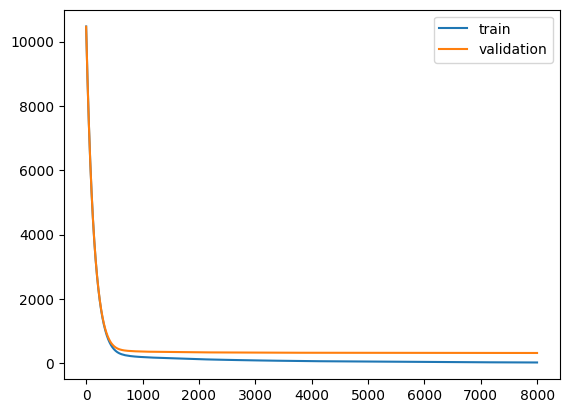

In [113]:
# my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)
my_model = XGBRegressor(**best_params)


my_model.fit(X_train, y_train, 
             eval_set=[(X_train, y_train),(X_val, y_val)], verbose=False)

results = my_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [114]:
# calculate the rmse on train and test set
from sklearn.metrics import mean_squared_error
from math import sqrt

y_train_pred = my_model.predict(X_train)
y_val_pred = my_model.predict(X_val)
y_test_pred = my_model.predict(X_test)

rmse_train_shuffled = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val_shuffled = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test_shuffled = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train_shuffled)
print("RMSE on validation set:", rmse_val_shuffled)
print("RMSE on test set:", rmse_test_shuffled)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("R2 on train set:", r2_train)
print("R2 on validation set:", r2_val)
print("R2 on test set:", r2_test)

RMSE on train set: 23.794565546126684
RMSE on validation set: 319.2130553161498
RMSE on test set: 345.49122771220186
R2 on train set: 0.9998469031877164
R2 on validation set: 0.9721722149863405
R2 on test set: 0.9685516291060372


In [115]:
# calculate the rmse on live set
live_X = live_df[ctrl_tag+ind_tag]
live_y = live_df[cfg.kpi1.tag1]

live_y_pred = my_model.predict(live_X)
rmse_live_shuffled = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live_shuffled)

r2_live = r2_score(live_y, live_y_pred)
print("R2 on live set:", r2_live)

RMSE on live set: 1351.0744393755383
R2 on live set: 0.10436962962525353


#### Hyperparameters Tuning and Model Evaluation on UnShuffled Data

In [116]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, **Config.xgboost_regressor_config.train_config)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1*2, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((18742, 53), (2343, 53), (2343, 53))

In [118]:
study_unshuffled = optuna.create_study(direction='minimize')
study_unshuffled.optimize(objective, n_trials=30)

[I 2023-09-15 09:44:22,814] A new study created in memory with name: no-name-09a2713c-5e59-4f9c-b733-d2b34ec53525
[I 2023-09-15 09:44:47,969] Trial 0 finished with value: 1009.1704060013119 and parameters: {'n_estimators': 9000, 'max_depth': 5, 'learning_rate': 0.0033940726058295464, 'subsample': 0.6220634082193662, 'colsample_bytree': 0.12534224673155156, 'min_child_weight': 1, 'reg_alpha': 0.0605506377588505, 'reg_lambda': 0.8491248022720816, 'early_stopping_rounds': 39}. Best is trial 0 with value: 1009.1704060013119.
[I 2023-09-15 09:44:52,125] Trial 1 finished with value: 1056.8819057082146 and parameters: {'n_estimators': 6000, 'max_depth': 2, 'learning_rate': 0.05872482260566341, 'subsample': 0.635215599900815, 'colsample_bytree': 0.5910378765839652, 'min_child_weight': 5, 'reg_alpha': 0.8145342136060048, 'reg_lambda': 0.8767905691061015, 'early_stopping_rounds': 41}. Best is trial 0 with value: 1009.1704060013119.
[I 2023-09-15 09:45:35,897] Trial 2 finished with value: 1032.66

In [119]:
best_params_unshuffled = study_unshuffled.best_params
best_params_unshuffled

{'n_estimators': 1000,
 'max_depth': 7,
 'learning_rate': 0.015484042987525422,
 'subsample': 0.2894575818009648,
 'colsample_bytree': 0.23138081116876774,
 'min_child_weight': 2,
 'reg_alpha': 0.36486723115904296,
 'reg_lambda': 0.09672628184005705,
 'early_stopping_rounds': 40}

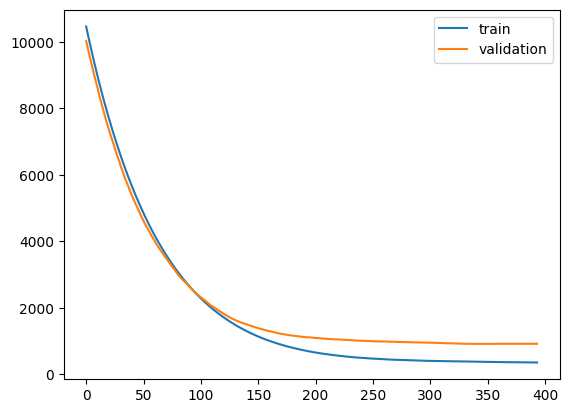

In [120]:
# my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)
my_model = XGBRegressor(**best_params_unshuffled)


my_model.fit(X_train, y_train, 
             eval_set=[(X_train, y_train),(X_val, y_val)], verbose=False)

results = my_model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

In [121]:
# calculate the rmse on train and test set
from sklearn.metrics import mean_squared_error
from math import sqrt

y_train_pred = my_model.predict(X_train)
y_val_pred = my_model.predict(X_val)
y_test_pred = my_model.predict(X_test)

rmse_train_unshuffled = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val_unshuffled = sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test_unshuffled = sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE on train set:", rmse_train_unshuffled)
print("RMSE on validation set:", rmse_val_unshuffled)
print("RMSE on test set:", rmse_test_unshuffled)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("R2 on train set:", r2_train)
print("R2 on validation set:", r2_val)
print("R2 on test set:", r2_test)

RMSE on train set: 365.9937149992143
RMSE on validation set: 908.7468338668685
RMSE on test set: 1220.4711101709654
R2 on train set: 0.9649441097188768
R2 on validation set: 0.6579887247084169
R2 on test set: 0.6126022493615155


In [122]:
# calculate the rmse on live set
live_X = live_df[ctrl_tag+ind_tag]
live_y = live_df[cfg.kpi1.tag1]

live_y_pred = my_model.predict(live_X)
rmse_live_unshuffled = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live_unshuffled)

r2_live = r2_score(live_y, live_y_pred)
print("R2 on live set:", r2_live)

RMSE on live set: 1161.600192963194
R2 on live set: 0.33796094917309705


#### Train on the whole data

In [126]:
# my_model = XGBRegressor(**Config.xgboost_regressor_config.model_config)
my_model = XGBRegressor(n_estimators=1000,
 max_depth=7,
 learning_rate=0.015484042987525422,
 subsample=0.2894575818009648,
 colsample_bytree=0.23138081116876774,
 min_child_weight=2,
 reg_alpha=0.36486723115904296,
 reg_lambda=0.09672628184005705)

my_model.fit(X, y, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.23138081116876774, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015484042987525422,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [127]:
# calculate the rmse on live set
live_X = live_df[ctrl_tag+ind_tag]
live_y = live_df[cfg.kpi1.tag1]

live_y_pred = my_model.predict(live_X)
rmse_live_unshuffled = sqrt(mean_squared_error(live_y, live_y_pred))
print("RMSE on live set:", rmse_live_unshuffled)

r2_live = r2_score(live_y, live_y_pred)
print("R2 on live set:", r2_live)

RMSE on live set: 1287.4936282543945
R2 on live set: 0.18668190793613104


#### Build the Final Model / Feature Selection Verification

In [90]:
cfg = Box(read_yaml('../src/conf/config.yaml'))
Config = Box(read_yaml('../src/conf/baseline.yaml'))

In [91]:
X = df[ctrl_tag+ind_tag]
y = df[cfg.kpi1.tag1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

In [92]:
import json
# load the best hyperparameters in json file
with open(Config.result_generating.v4.best_parameters_path, 'r') as f:
    best_params = json.load(f)

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 6000, 'max_depth': 8, 'learning_rate': 0.024073967177278926, 'subsample': 0.8285695099453828, 'colsample_bytree': 0.38285601818979814, 'min_child_weight': 7, 'reg_alpha': 0.21431723264863356, 'reg_lambda': 0.5034393995549985, 'early_stopping_rounds': 26}


In [93]:
# my_model = XGBRegressor(**best_params)
# my_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

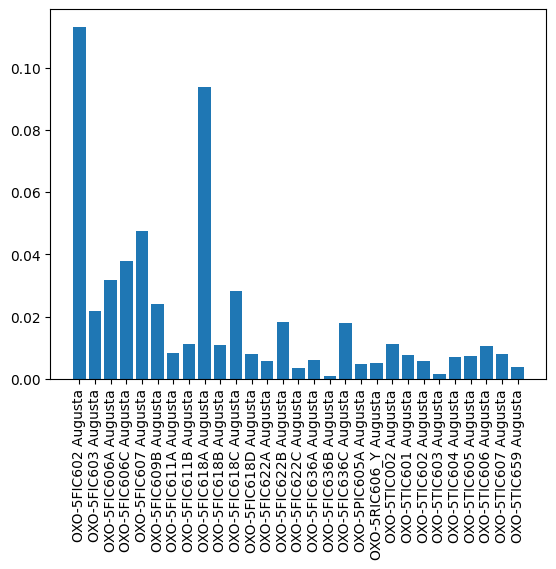

In [94]:
# load the model
loaded_model = pickle.load(open(Config.result_generating.v4.model_path, "rb"))
# get the feature importance for ctrl_tag
importance = loaded_model.feature_importances_[:len(ctrl_tag)]
# plot feature importance, add names
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], ctrl_tag, rotation='vertical')
plt.show()

In [95]:
# calculate the rmse on train and test set
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)

rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("RMSE on train set:", rmse_train)
print("RMSE on test set:", rmse_test)
print("R2 on train set:", r2_train)
print("R2 on test set:", r2_test)

RMSE on train set: 81.02628868420457
RMSE on test set: 68.27944185541608
R2 on train set: 0.9982278820407962
R2 on test set: 0.9977125575255488


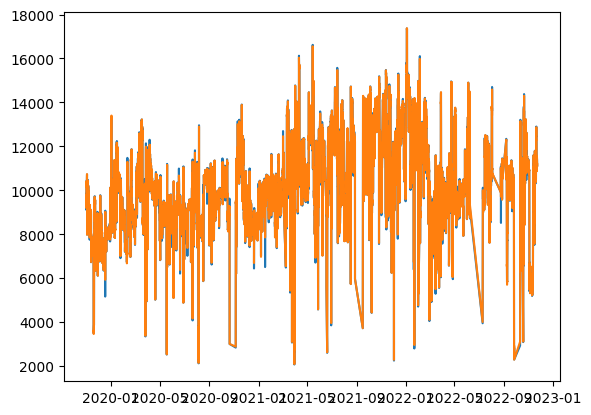

In [18]:
plt.plot(X_train.index, y_train)
plt.plot(X_train.index, y_train_pred)

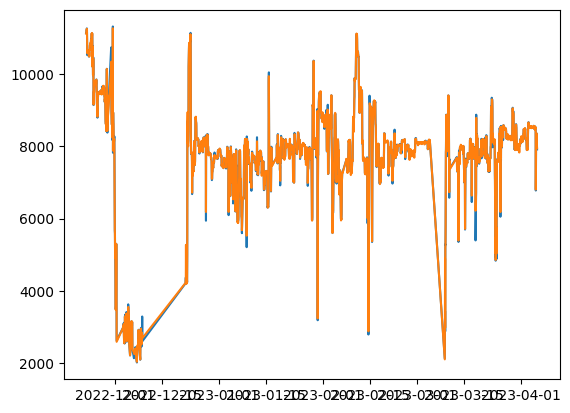

In [19]:
plt.plot(X_test.index, y_test)
plt.plot(X_test.index, y_test_pred)

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

# y_train_pred = loaded_model.predict(X_train)
# y_test_pred = loaded_model.predict(X_test)

# rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
# rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))

# print("RMSE on train set:", rmse_train)
# print("RMSE on test set:", rmse_test)

RMSE on train set: 26.82208185262603
RMSE on test set: 239.2835996712326


#### Optimization

In [19]:
from tqdm.notebook import tqdm_notebook

from utils.util import read_json, read_pickle, write_json
from utils.eda_tools import single_column_vis, lines_plot
from utils.optimization_result_vis import Controllable_Value_Plot

from optimization.Features import Feature_Info, get_feature_full_name
from optimization.Data import IncomingData, Missing_info
from optimization.Bounds import Bounds
from optimization.Dual_Annealing_Optimization import Dual_Annealing_Optimization

In [20]:
ctrl_tag_length = len(ctrl_tag)
difference_quantile = (df.iloc[:, :ctrl_tag_length].shift(1)-df.iloc[:, :ctrl_tag_length]).quantile(0.95)

mean_of_controllable = df.iloc[:, :ctrl_tag_length].mean()

ctrl_change_rate = (difference_quantile/mean_of_controllable).values

# Upper and Lower bounds historically, which directives can never exceed
quantile_lower = [df[tag].quantile(0.05) for tag in ctrl_tag]
quantile_upper = [df[tag].quantile(0.95) for tag in ctrl_tag]
bounds = [list(bound) for bound in zip(quantile_lower, quantile_upper)]

cont_dict = {tag:{'max_rate': rate,'bounds':bound} for tag,rate,bound in zip(ctrl_tag, ctrl_change_rate, bounds)}

# generate optimizer.json
opt_dict = dict()
opt_dict['controllable'] = cont_dict
opt_dict['noncontrollable'] = [tag for tag in ind_tag]

opt_dict['kwargs'] = {'maxiter': 10}
opt_dict['additional'] = {'tag2': [Config.kpi1.tag2], 'tag3': [Config.kpi1.tag3], 'tag4': [Config.kpi1.tag4], 'tag5': [Config.kpi1.tag5]}

In [21]:
opt_dict.keys()

dict_keys(['controllable', 'noncontrollable', 'kwargs', 'additional'])

In [22]:
denominator_tags = [Config.kpi1.tag2, Config.kpi1.tag3, Config.kpi1.tag4, Config.kpi1.tag5]
test_df = df[denominator_tags+ctrl_tag+ind_tag].loc[Config.test_start_time:]

In [23]:
from datetime import datetime

tag1 = df[Config.kpi1.tag1].loc[Config.test_start_time:]
tag2 = df[Config.kpi1.tag2].loc[Config.test_start_time:]
tag3 = df[Config.kpi1.tag3].loc[Config.test_start_time:]
tag4 = df[Config.kpi1.tag4].loc[Config.test_start_time:]
tag5 = df[Config.kpi1.tag5].loc[Config.test_start_time:]

denominator = (tag2 + tag3)*1000 + tag4 + tag5
# convert into a list
denominator_list = denominator.values.tolist()

# get the index of the test_df in the datetime.datetime type, turn into a list
time_stamps = test_df.index.format()
time_stamps = [datetime.strptime(time_stamp, '%Y-%m-%d %H:%M:%S') for time_stamp in time_stamps]

In [24]:
test_df.columns = [column+'___Value' for column in test_df.columns]

features = Feature_Info(opt_dict)
incoming_data = IncomingData(test_df, features)

# bounds = Bounds(incoming_data).final_bounds()
bounds = [tuple(bound) for bound in zip(quantile_lower, quantile_upper)]

# my_model = pickle.load(open(Config.xgboost_regressor_config.v4_model_path, "rb"))
# Optimization = Dual_Annealing_Optimization(incoming_data, loaded_model, denominator_list, time_stamps)
Optimization = Dual_Annealing_Optimization(incoming_data, loaded_model)

In [25]:
nrows = incoming_data.value.shape[0]
optimal_controls = [None] * nrows
optimized_final_product = [None] * nrows

for i in tqdm_notebook(range(nrows)):
    timestamp = incoming_data.value.index[i]
    #bound = bounds[i]  
    bound = bounds
    
    optimal_controls_vals, optimized_product = Optimization.run_optimization(timestamp, bound)
    optimal_controls[i] = optimal_controls_vals
    optimized_final_product[i] = optimized_product

  0%|          | 0/2604 [00:00<?, ?it/s]

In [26]:
test_df.columns = [column.replace('___Value', '') for column in test_df.columns]

In [27]:
result_df = pd.DataFrame(optimal_controls, columns=[tag + '_Optimized' for tag in ctrl_tag], index=test_df.index[:nrows])
result_df['5FI696_optimized'] = np.array(optimized_final_product).flatten()
result_df['5FI696_before_optimized'] = (loaded_model.predict(test_df[ctrl_tag+ind_tag]))

In [28]:
test_df.shape, result_df.shape

((2604, 57), (2604, 31))

In [29]:
# save result_df to csv
result_df.to_csv(Config.result_generating.v4.result_df_path)

In [30]:
final_df = pd.merge(result_df, test_df, left_index=True, right_index=True) # 62(60 cvs + 2 LNG) columns of the result_df + 584 columns of the test_df

In [130]:
Controllables_number_in_one_plot = 7

In [ ]:
for i in range(len(ctrl_tag)//7):
    Controllable_Value_Plot(final_df, ctrl_tag[Controllables_number_in_one_plot*i:Controllables_number_in_one_plot*(i+1)]).write_html(Config.result_generating.v4.visualization.controllable_result_path[i])

In [33]:
df_graph = pd.DataFrame()
df_graph['Actual 5FI696 Level'] = df[Config.kpi1.tag1].loc['2022-11-22 12:00:00':]
df_graph['Optimized 5FI696 Level'] = final_df['5FI696_optimized']
df_graph['Predicted 5FI696 Level'] = final_df['5FI696_before_optimized']

lines_plot(df_graph, ['Actual 5FI696 Level', 'Optimized 5FI696 Level', 'Predicted 5FI696 Level']).write_html(Config.result_generating.v4.visualization.optimized_target_level_path)

In [34]:
kpi_before_optimized = final_df['5FI696_before_optimized']/ ((tag2 + tag3)*1000 + tag4 + tag5)
kpi_optimized = final_df['5FI696_optimized']/ ((tag2 + tag3)*1000 + tag4 + tag5)

In [35]:
import plotly.graph_objects as go

trace1 = go.Scatter(x=kpi_optimized.index, y=kpi_before_optimized.values, name='kpi_before_optimized')
trace2 = go.Scatter(x=kpi_optimized.index, y=kpi_optimized.values, name='kpi_optimized')

# Create the figure and specify the layout
fig = go.Figure(data=[trace1, trace2])
fig.update_layout(title='kpi before and after optimization',
                xaxis_title='Date',
                yaxis_title='Kpi Value',
                width=1200,
                height=600)

# Display the plot
fig.show()

In [36]:
# delete where kpi_optimized is larger than 2, leave the deleted as blank
kpi_optimized[kpi_optimized > 2] = np.nan
kpi_before_optimized[kpi_before_optimized > 2] = np.nan

In [37]:
# make a dataframe of kpi_optimized and kpi_before_optimized as two columns
kpi_df = pd.DataFrame()
kpi_df['kpi_optimized'] = kpi_optimized
kpi_df['kpi_before_optimized'] = kpi_before_optimized
# save the dataframe as csv
kpi_df.to_csv(Config.result_generating.v4.kpi1_optimization_path)

In [38]:
import plotly.graph_objects as go

trace1 = go.Scatter(x=kpi_optimized.index, y=kpi_before_optimized.values, name='kpi1_before_optimized')
trace2 = go.Scatter(x=kpi_optimized.index, y=kpi_optimized.values, name='kpi1_optimized')
layout = go.Layout(
    annotations=[
        dict(
            x=0,
            y=0.84,
            xref='paper',
            yref='y',
            text='0.84',
            showarrow=False,
            xanchor='right',
            yanchor='middle',
            font=dict(
                color='red'
            )
        ),
        dict(
            x=0,
            y=0.9,
            xref='paper',
            yref='y',
            text='0.9',
            showarrow=False,
            xanchor='right',
            yanchor='middle',
            font=dict(
                color='red'
            )
        )
    ]
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.update_layout(title='KPI1 Before and After Optimization',
                xaxis_title='Date',
                yaxis_title='Kpi1 Value',
                width=1200,
                height=600,
                yaxis=dict(
                    range=[0, 1.5],
                    showgrid=True
                    )
)
# Line Horizontal
fig.add_shape(
    type="line",
    x0=kpi_optimized.index[0],
    y0=0.84,
    x1=kpi_optimized.index[-1],
    y1=0.84,
    line=dict(
        color="black",
        width=2,
        dash="dashdot",
    ),
    name='target range'
)
fig.add_shape(
    type="line",
    x0=kpi_optimized.index[0],
    y0=0.9,
    x1=kpi_optimized.index[-1],
    y1=0.9,
    line=dict(
        color="black",
        width=2,
        dash="dashdot",
    ),
    name='target range'
)
fig.write_html(Config.result_generating.v4.visualization.kpi_before_and_after_optimization_path)
fig.show()

In [39]:
from utils.optimization_result_vis import find_nearest_point

# Client's demand, for each time stamp, we use euclidean_dist algorithm to find the most similar point in the training data

TRAINING_TESTING_CUTOFF_DATE = '2022-01-01'

result = pd.DataFrame()
for i in range(final_df.shape[0]):
    temp = find_nearest_point(final_df.iloc[[i],:], df, ctrl_tag, TRAINING_TESTING_CUTOFF_DATE)
    result = pd.concat([result, temp])
result.index = final_df.index

In [40]:
result = result.drop(columns=['Euclidean_Dist_Validation1', 'Euclidean_Dist_Validation2','Euclidean_Dist_Validation3','Euclidean_Dist_Validation4'])

In [41]:
final_df = pd.concat([final_df, result], axis=1)
'''
final_df:
23(21 cvs + 1*2 LNG) columns of the result_df (optimized result)
+ 
197 columns of the test_df (original data, cvs + non-cvs)
+
84 (21 * 4) columns of the validation result for each cv
+
4 (1 * 4) columns of the validation timestamp (most similar timestamp to the current timestamp in terms of the 21 cvs) for the whole 21 cvs
'''

'\nfinal_df:\n23(21 cvs + 1*2 LNG) columns of the result_df (optimized result)\n+ \n197 columns of the test_df (original data, cvs + non-cvs)\n+\n84 (21 * 4) columns of the validation result for each cv\n+\n4 (1 * 4) columns of the validation timestamp (most similar timestamp to the current timestamp in terms of the 21 cvs) for the whole 21 cvs\n'

In [42]:
final_df.to_csv(Config.result_generating.v4.outputing.output_path)

#### Validation

In [43]:
final_df = pd.read_csv(Config.result_generating.v4.outputing.output_path, index_col=0, parse_dates=[0])
final_df.shape

(2604, 208)

In [44]:
train_df = df[ctrl_tag].loc[:'2022-01-01']
train_df.shape

(17740, 29)

In [45]:
test_df = df[ctrl_tag].loc['2022-01-01':]
test_df.shape

(8316, 29)

In [46]:
# analyze the missing value of train_df
test_df.isnull().sum()

OXO-5FIC602 Augusta      0
OXO-5FIC603 Augusta      0
OXO-5FIC606A Augusta     0
OXO-5FIC606C Augusta     0
OXO-5FIC607 Augusta      0
OXO-5FIC609B Augusta     0
OXO-5FIC611A Augusta     0
OXO-5FIC611B Augusta     0
OXO-5FIC618A Augusta     0
OXO-5FIC618B Augusta     0
OXO-5FIC618C Augusta     0
OXO-5FIC618D Augusta     0
OXO-5FIC622A Augusta     0
OXO-5FIC622B Augusta     0
OXO-5FIC622C Augusta     0
OXO-5FIC636A Augusta     0
OXO-5FIC636B Augusta     0
OXO-5FIC636C Augusta     0
OXO-5PIC605A Augusta     0
OXO-5RIC606_Y Augusta    0
OXO-5TIC002 Augusta      0
OXO-5TIC601 Augusta      0
OXO-5TIC602 Augusta      0
OXO-5TIC603 Augusta      0
OXO-5TIC604 Augusta      0
OXO-5TIC605 Augusta      0
OXO-5TIC606 Augusta      0
OXO-5TIC607 Augusta      0
OXO-5TIC659 Augusta      0
dtype: int64

In [47]:
# from utils.optimization_result_vis import generate_validation_result

# new_final_df = generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')
# new_final_df

In [48]:
# find the missing index of df2
missing_index = df[df.isnull().any(axis=1)].index
missing_index
# remove the missing index of df2
df = df.drop(missing_index)

In [49]:
missing_index = final_df[final_df.isnull().any(axis=1)].index
len(missing_index)
# remove the missing index of final_df
final_df = final_df.drop(missing_index)

In [50]:
# use the updated function in Jupyter notebook without restarting the kernel
import importlib
import utils.optimization_result_vis  # import the module

importlib.reload(utils.optimization_result_vis)  # reload the module

res = utils.optimization_result_vis.generate_validation_result(final_df, df, ctrl_tag, '2022-01-01')

In [51]:
res.head()

,OXO-5FIC602 Augusta_Validation1,OXO-5FIC602 Augusta_Validation2,OXO-5FIC602 Augusta_Validation3,OXO-5FIC602 Augusta_Validation4,OXO-5FIC603 Augusta_Validation1,OXO-5FIC603 Augusta_Validation2,OXO-5FIC603 Augusta_Validation3,OXO-5FIC603 Augusta_Validation4,OXO-5FIC606A Augusta_Validation1,OXO-5FIC606A Augusta_Validation2,...,OXO-5TIC607 Augusta_Validation3,OXO-5TIC607 Augusta_Validation4,OXO-5TIC659 Augusta_Validation1,OXO-5TIC659 Augusta_Validation2,OXO-5TIC659 Augusta_Validation3,OXO-5TIC659 Augusta_Validation4,Nearest_TimeStamp_Validation1,Nearest_TimeStamp_Validation2,Nearest_TimeStamp_Validation3,Nearest_TimeStamp_Validation4
0,6531.939675,6531.973411,6431.586759,6596.24233,0.0,0.0,0.0,0.0,1123.137574,1122.718923,...,128.149784,129.328473,297.944153,298.025229,297.634313,297.350527,2021-03-27 10:00:00,2021-03-27 09:00:00,2021-03-27 20:00:00,2021-03-27 13:00:00
0,6531.939675,6531.973411,6431.586759,6596.24233,0.0,0.0,0.0,0.0,1123.137574,1122.718923,...,128.149784,129.328473,297.944153,298.025229,297.634313,297.350527,2021-03-27 10:00:00,2021-03-27 09:00:00,2021-03-27 20:00:00,2021-03-27 13:00:00
0,6150.402303,5644.628906,6724.570435,5686.979256,0.0,0.0,0.0,0.0,1037.099379,950.08885,...,128.683771,131.605484,296.844942,299.065742,297.074342,298.459857,2021-03-24 04:00:00,2021-03-25 09:00:00,2021-03-30 06:00:00,2021-03-25 14:00:00
0,6150.402303,5644.628906,6154.397253,6154.397253,0.0,0.0,0.0,0.0,1037.099379,950.08885,...,131.628986,131.610974,296.844942,299.065742,298.077669,298.016331,2021-03-24 04:00:00,2021-03-25 09:00:00,2021-03-24 08:00:00,2021-03-24 09:00:00
0,6150.402303,5644.628906,6724.570435,5711.037427,0.0,0.0,0.0,0.0,1037.099379,950.08885,...,128.683771,131.554933,296.844942,299.065742,297.074342,298.551559,2021-03-24 04:00:00,2021-03-25 09:00:00,2021-03-30 06:00:00,2021-03-25 16:00:00


In [52]:
indices

NameError: name 'indices' is not defined

: 

In [ ]:
indices.shape

(8492, 4)

In [ ]:
res.to_csv(Config.result_generating.v3.outputing.output_path)